In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import time
import math
import itertools
import os
import networkx as nx
%matplotlib inline
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

In [ ]:
import os

def create_dir(path, log=False):
    if not os.path.exists(path):
        if log:
            print('The directory', path, 'does not exist and will be created')
        os.makedirs(path)
    else:
        if log:
            print('The directory', path, ' already exists')

In [ ]:
def get_df(simulator, seed, report_file_path):
  IDP_brute_force = bool(int(report_file_path.split('_')[-(3+simulator.count('_'))][0]))
  IDP_topdown_min_cut = bool(int(report_file_path.split('_')[-(3+simulator.count('_'))][1]))
  IDP_topdown_qubo = bool(int(report_file_path.split('_')[-(3+simulator.count('_'))][2]))
  IDP_gate_based = bool(int(report_file_path.split('_')[-(3+simulator.count('_'))][3]))

  #report_file_obj = open(os.path.join(report_save_location,report_file_path),'r')
  report_file_obj = open(os.path.join(report_file_path),'r')
  table_contents = [line.replace('\n','').split('__') for line in report_file_obj.readlines()]


  def is_float(value):
    try:
      float(value)
      return True
    except:
      return False

  for col_num, cell in enumerate(table_contents[0][2:]):
    if is_float(cell):
      for row in table_contents:
        row[col_num+2] = np.float(row[col_num+2])

  #view output table
  def highlight_false(s, column):
      is_false = pd.Series(data=False, index=s.index)
      is_false[column] = round(s.loc[column],2)<1
      return ['color: #ff8888' if is_false.any() else '' for v in is_false]

  base_cols = ['Distribution', 'No. of Agents']
  sub_cols = ['', '']

  if IDP_brute_force:
      base_cols = base_cols+['Brute Force']*3
      sub_cols=sub_cols+['Result', 'Value', 'TTE']
  if IDP_topdown_min_cut:
      base_cols = base_cols+['Top-down approach using min-cut']*4
      sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']
  if IDP_topdown_qubo:
      base_cols = base_cols+['Top-down approach using qubo']*4
      sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality']
  if IDP_gate_based:
      base_cols = base_cols+['Qiskit QAOA']*5
      sub_cols=sub_cols+['Result', 'Value', 'TTE', 'Quality', 'reps (p)']


  column_arrays = [base_cols, sub_cols]


  #df = pd.DataFrame(table_contents, columns=table_headers)
  df = pd.DataFrame(table_contents, columns=pd.MultiIndex.from_arrays(column_arrays))

  for col in df.columns:
    try:
      if 'No. of Agents' in col or 'reps (p)' in col:
        df[col] = df[col].astype(int)
      elif 'Result' in col:
        raise
      else:
        df[col] = df[col].astype(float)
    except:
      continue

  df.sort_values(['Distribution','No. of Agents'], ascending=[True, True], inplace=True)

  df = df.round(decimals = 2)

  return df

## IDP (Exact), Q-SING (Classical) vs Q-SING (QAOA)

In [ ]:
algoName = "QuACS"

#### Plot runtimes

In [ ]:
simulator = 'aer_simulator'
seed = 123
report_file_path = '/content/drive/MyDrive/Saarland/QAI/gate_based_GCS/IDP_report_1111_123_aer_simulator.txt'

In [ ]:
df = get_df(simulator, seed, report_file_path)

In [ ]:
data = pd.concat([df["Distribution"] , df["No. of Agents"], df[('Brute Force', 'TTE')], 
                 df[('Top-down approach using min-cut', 'TTE')], df[('Qiskit QAOA', 'TTE')]], axis = 1)
data.columns = ["Distribution", "n", "IDP", f"{algoName}$_c$", f"{algoName}$_q$"]
data.head()

In [ ]:
folder = os.path.join('QAOA_results', str(123))

out_folder= 'GCSG Plots'
current_folder = os.path.join(folder, out_folder)
create_dir(current_folder)

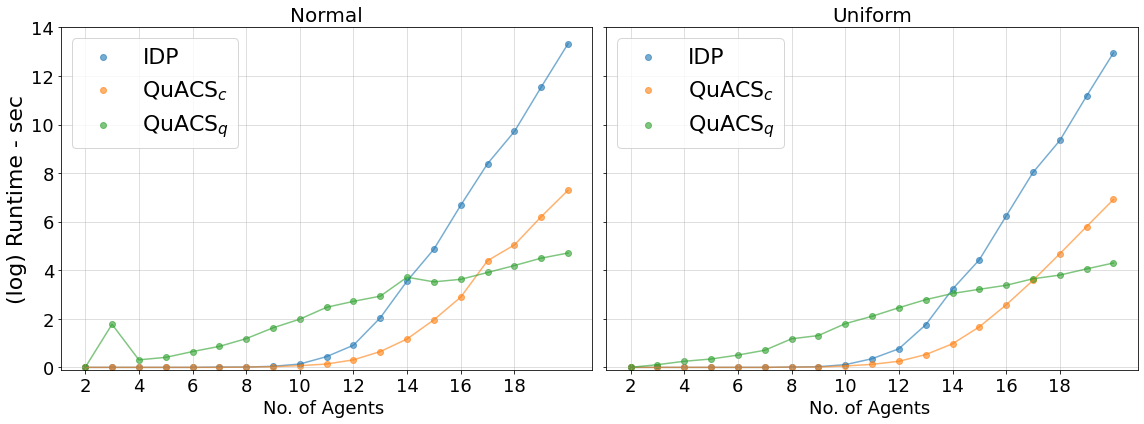

In [ ]:
font=14

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,6))
fig.set_tight_layout(True)
ax[0].set_ylabel(r"(log) Runtime - sec", fontsize=font+8)
ax[0].set_ylim(-.1, 1.1)
plt.setp(ax, xticks=np.arange(0, 20, 2), yticks = np.arange(0, 16, 2))

i=0

for distr in df.Distribution.unique():
    if distr == "laplace":
        continue
    current_data = data[data.Distribution == distr]

    #plt.figure(figsize=(8,5))
    x = current_data['n'].astype(int).to_numpy()

    y_IDP = np.log2(current_data['IDP'].astype(float).to_numpy()+1)
    y_gcsq_c = np.log2(current_data[f'{algoName}$_c$'].astype(float).to_numpy()+1)
    y_gcsq_q = np.log2(current_data[f'{algoName}$_q$'].astype(float).to_numpy()+1)

    ax[i].plot(x, y_IDP, alpha=.6)
    ax[i].scatter(x, y_IDP, label='IDP', alpha=.6)

    ax[i].plot(x, y_gcsq_c, alpha=.6)
    ax[i].scatter(x, y_gcsq_c, label=f'{algoName}$_c$', alpha=.6)

    ax[i].plot(x, y_gcsq_q, alpha=.6)
    ax[i].scatter(x, y_gcsq_q, label=f'{algoName}$_q$', alpha=.6)

    #plt.ylabel(r'(log scale) Time to Execute - sec',fontdict={'fontsize':font+8})
    ax[i].set_xlabel(r'No. of Agents ',fontdict={'fontsize':font+4})
    ax[i].tick_params(axis="both", labelsize=font+4)
    #plt.ylim(-.1, 1.1)
    #plt.xticks(ticks=np.arange(0, 20, 2))
    #plt.yticks(ticks=np.arange(0, 20, 2))
    #plt.tick_params(axis='both', which='major', labelsize=font)
    ax[i].set_title(distr.title(), fontdict={'fontsize':font+6})
    ax[i].grid(alpha=.5)
    ax[i].legend(fontsize=font+8, loc="upper left")
    i+=1

#lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes][0]
#lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
#fig.legend(lines, labels)
file = os.path.join(current_folder, simulator+'_runtimes_log.png')
plt.savefig(file, dpi=500, bbox_inches = "tight")
plt.show()

#### Plot runtimes with analytic continuation

In [ ]:
def fit_function_idp(x, a1,a2,a3):
    local_variables = locals()
    co_effs = local_variables
    co_effs = list(co_effs.values())[1:][::-1]
    value = 0
    for i,coeff in enumerate(co_effs):
      value += coeff*np.power(x,i)
    return value


def fit_function_gcsq_classical(x, a1,a2,a3):
    local_variables = locals()
    co_effs = local_variables
    co_effs = list(co_effs.values())[1:][::-1]
    value = 0
    for i,coeff in enumerate(co_effs):
      value += coeff*np.power(x,i)
    return value

def fit_function_gcsq_quantum(x, a1,a2):
    local_variables = locals()
    co_effs = local_variables
    co_effs = list(co_effs.values())[1:][::-1]
    value = 0
    for i,coeff in enumerate(co_effs):
      value += coeff*np.power(x,i)
    return value

In [ ]:
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

x = [20 21 22 23 24 25 26 27 28 29 30]
Times to Execute for normal distribution
x = [20 21 22 23 24 25 26 27 28 29 30]
Times to Execute for uniform distribution


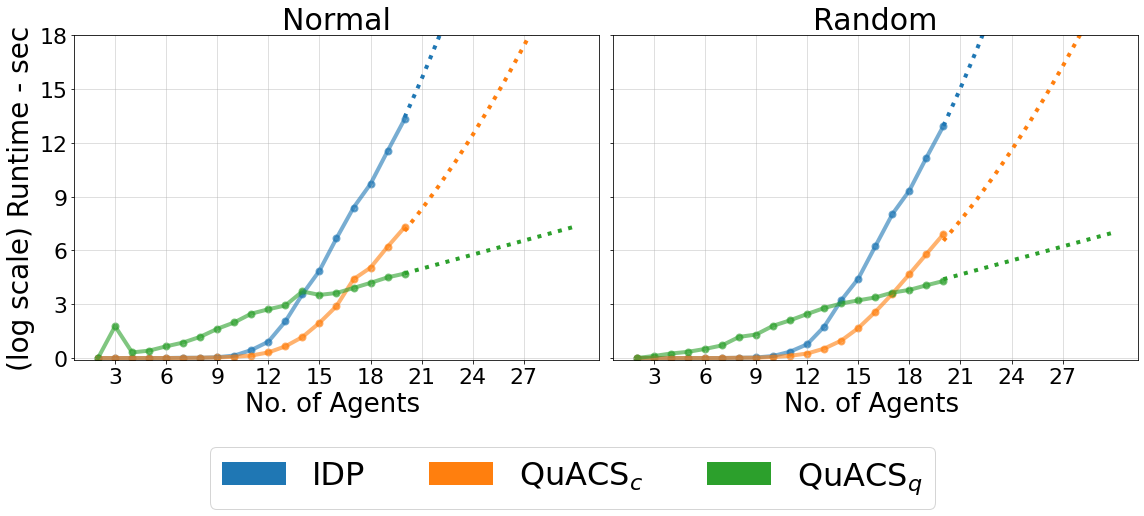

In [ ]:
font=16

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,6))
fig.set_tight_layout(True)
ax[0].set_ylabel(r"(log scale) Runtime - sec", fontsize=font+12)
ax[0].set_ylim(-.1, 1.1)
plt.setp(ax, xticks=np.arange(0, 30, 3), yticks = np.arange(0, 21, 3))

i=0

for distr in df.Distribution.unique():
    if distr == "laplace":
        continue
    current_data = data[data.Distribution == distr]

    x = current_data['n'].to_numpy()
    x_ints = np.array(list(map(int,x)))

    y_IDP = np.log2(current_data['IDP'].astype(float).to_numpy()+1)
    

    y_gcsq_c = np.log2(current_data[f"{algoName}$_c$"].astype(float).to_numpy()+1)
    

    y_gcsq_q = np.log2(current_data[f"{algoName}$_q$"].astype(float).to_numpy()+1)
    

    ax[i].plot(x, y_IDP, alpha=.6, linewidth = 4)
    ax[i].scatter(x, y_IDP, label='IDP', alpha=.6, linewidth = 2)

    ax[i].plot(x, y_gcsq_c, alpha=.6, linewidth = 4)
    ax[i].scatter(x, y_gcsq_c, label=f"{algoName}$_c$", alpha=.6, linewidth = 2)

    ax[i].plot(x, y_gcsq_q, alpha=.6, linewidth = 4)
    ax[i].scatter(x, y_gcsq_q, label=f"{algoName}$_q$", alpha=.6, linewidth = 2)


    x_projection = np.arange(2,31)
    popt, pcov = curve_fit(fit_function_idp, x_ints, y_IDP)
    y_IDP_projection = fit_function_idp(x_projection, *popt)

    popt, pcov = curve_fit(fit_function_gcsq_classical, x_ints, y_gcsq_c)
    y_gcsq_c_projection = fit_function_gcsq_classical(x_projection, *popt)

    popt, pcov = curve_fit(fit_function_gcsq_quantum, x_ints, y_gcsq_q)
    y_gcsq_q_projection = fit_function_gcsq_quantum(x_projection, *popt)

    projection_start_index = 18

    print('x =',np.array(list(map(str,np.arange(2,31))))[projection_start_index:].astype(int))

    ax[i].plot(np.array(list(map(str,np.arange(2,31))))[projection_start_index:].astype(int),y_IDP_projection[projection_start_index:], linestyle = 'dotted', color = '#1f77b4', linewidth = 4)
    ax[i].plot(np.array(list(map(str,np.arange(2,31))))[projection_start_index:].astype(int),y_gcsq_c_projection[projection_start_index:], linestyle = 'dotted', color = '#ff7f0e', linewidth = 4)
    ax[i].plot(np.array(list(map(str,np.arange(2,31))))[projection_start_index:].astype(int),y_gcsq_q_projection[projection_start_index:], linestyle = 'dotted', color = '#2ca02c', linewidth = 4)

    ax[i].set_xlabel(r'No. of Agents ',fontdict={'fontsize':font+10})
    ax[i].set_title(distr.title(), fontdict={'fontsize':font+14})
    if distr == 'uniform':
      ax[i].set_title("Random", fontdict={'fontsize':font+14})
    ax[i].tick_params(axis="both", labelsize=font+6)
    ax[i].grid(alpha=.5)
    #ax[1].legend(fontsize=font+8, loc="upper left")
    print("Times to Execute for",distr,"distribution")
    i+=1
# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes][1:2]
# # print(len([ax.get_legend_handles_labels() for ax in fig.axes]))
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]

# legend_elements = [Patch(facecolor='orange', edgecolor='r', label='Color Patch')]

lines = [Patch(facecolor='#1f77b4'),Patch(facecolor='#ff7f0e'),Patch(facecolor='#2ca02c')]
labels = ["IDP", f"{algoName}$_c$", f"{algoName}$_q$"]

fig.legend(lines, labels, fontsize=font+16, loc='lower center', ncol=3, bbox_to_anchor=[0, ax[0].get_position().y0-0.35,1,1], bbox_transform=fig.transFigure)




# leg = plt.legend()
# # get the lines and texts inside legend box
# leg_lines = leg.get_lines()
# leg_texts = leg.get_texts()
# # bulk-set the properties of all lines and texts
# plt.setp(leg_lines, linewidth=4)
# plt.setp(leg_texts, fontsize='x-large')


# leg = plt.legend()

# # change the line width for the legend
# for legobj in leg.legendHandles:
#     legobj.set_linewidth(2.0)

# leg = plt.legend()
# # get the lines and texts inside legend box
# leg_lines = leg.get_lines()
# leg_texts = leg.get_texts()
# # bulk-set the properties of all lines and texts
# plt.setp(leg_lines, )
# plt.setp(leg_texts, fontsize=font+14)

file = os.path.join(current_folder, simulator+'_runtimes_log_continuation.png')
plt.savefig(file, dpi=500, bbox_inches = "tight")
plt.show()

#### Plot approximation error

In [ ]:
simulator = 'aer_simulator'
seed = 123
report_file_path = '/content/drive/MyDrive/Saarland/QAI/gate_based_GCS/IDP_report_1111_123_aer_simulator.txt'

In [ ]:
df = get_df(simulator, seed, report_file_path)

In [ ]:
untrained_quality = {}
untrained_quality_classical = {}

for distr in ['normal','uniform']:
  temp = df[df['Distribution']== distr]
  untrained_quality[distr] = list(temp[('Qiskit QAOA', 'Quality')])
  untrained_quality_classical[distr] = list(temp[('Top-down approach using min-cut', 'Quality')])

In [ ]:
simulator = 'aer_simulator'
seed = 123
report_file_path = '/content/drive/MyDrive/Saarland/QAI/gate_based_GCS/TrainedPIDP_report_1111_123_aer_simulator.txt'

In [ ]:
df = get_df(simulator, seed, report_file_path)

In [ ]:
trained_quality = {}
for distr in ['normal','uniform']:
  temp = df[df['Distribution']== distr]
  trained_quality[distr] = list(temp[('Qiskit QAOA', 'Quality')])

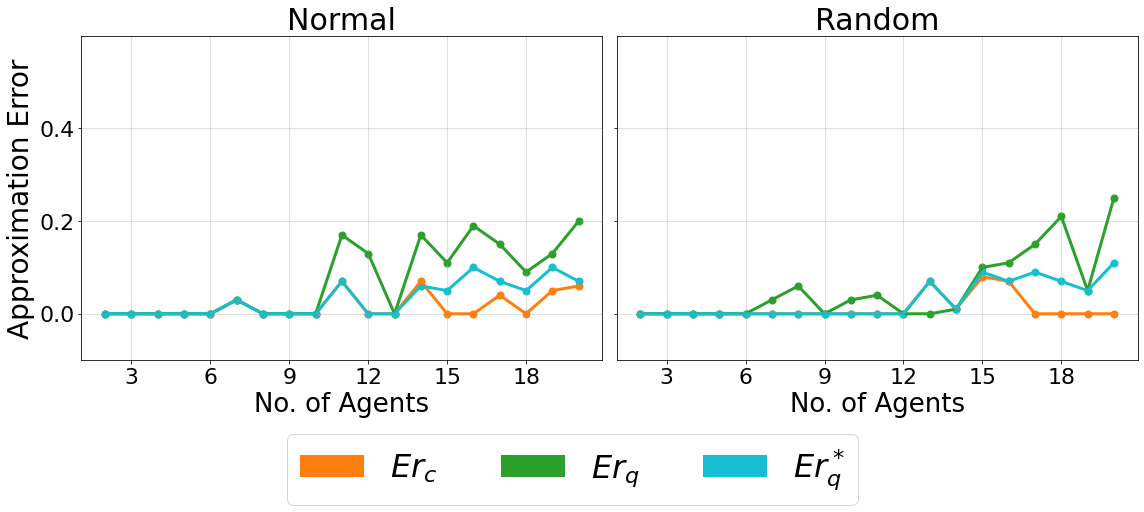

In [ ]:
#folder = os.path.join('/content/drive/MyDrive/Saarland/QAI/gate_based_GCS/QAOA_results', str(123))

folder = os.path.join('QAOA_results', str(123))
out_folder= 'GCSG Plots'
df=df
save=True
font=16

fig, ax = plt.subplots(1, 2, sharey=True, figsize=(16,6))
fig.set_tight_layout(True)
ax[0].set_ylim(-.1, 0.6)
ax[0].set_ylabel(r"Approximation Error", fontsize=font+12)
plt.setp(ax, xticks=np.arange(0, 27, 3), yticks=np.arange(0, 0.6, 0.2))
# plt.setp(ax, )


current_folder = os.path.join(folder, out_folder )
create_dir(current_folder)

i=0

distrs = ['normal', 'uniform']

for distr in distrs:
    #if distr == "uniform":
    #    continue
    # if i==1:
      # data = df[df.Distribution == 'laplace']
    # else:
      # data = df[df.Distribution == 'normal']
    # print(distr)
    # data = df[df.Distribution == distr]

    # n = np.array(list(map(int,data['No. of Agents'])))

    x = range(2,21)

    y_classical = 1 - np.array(untrained_quality_classical[distr])

    y_QAOA = 1 - np.array(trained_quality[distr])

    y_QAOA_not_trained = 1 - np.array(untrained_quality[distr])


    ax[i].scatter(x, y_classical, label=f"$Er_c$", color='#ff7f0e', linewidth = 2)
    ax[i].plot(x, y_classical, color='#ff7f0e', linewidth = 3)
    
    # if i:
    ax[i].scatter(x, y_QAOA_not_trained[:19], label=f"$Er_q$", color='#2ca02c', linewidth = 2)
    ax[i].plot(x, y_QAOA_not_trained[:19], color='#2ca02c', linewidth = 3)
    # else:
      # ax[i].scatter(x, y_QAOA_not_trained[19:], label=f"{algoName} QAOA (p=1)", color='#2ca02c')
      # ax[i].plot(x, y_QAOA_not_trained[19:], color='#2ca02c')

    ax[i].scatter(x, y_QAOA, label=f"$Er_q^*$", color = '#17becf', linewidth = 2)
    ax[i].plot(x, y_QAOA, color = '#17becf', linewidth = 3)

    ax[i].tick_params(axis="both", labelsize=font+6)

    ax[i].set_xlabel(r'No. of Agents',fontdict={'fontsize':font+10})

    ax[i].grid(alpha=.5)
    ax[i].set_title(distrs[i].title(), fontdict={'fontsize':font+14})
    if distr == 'uniform':
      ax[i].set_title('Random', fontdict={'fontsize':font+14})
    # ax[i].legend(fontsize=font+12)
    i+=1
# lines_labels = [ax.get_legend_handles_labels() for ax in fig.axes][:1]
# # print(len([ax.get_legend_handles_labels() for ax in fig.axes]))
# lines, labels = [sum(lol, []) for lol in zip(*lines_labels)]
# fig.legend(lines, labels, fontsize=font+14, loc='lower center', ncol=3, bbox_to_anchor=[0, ax[0].get_position().y0-0.32,1,1], bbox_transform=fig.transFigure)

lines = [Patch(facecolor='#ff7f0e'),Patch(facecolor='#2ca02c'),Patch(facecolor='#17becf')]
labels = [f"$Er_c$", f"$Er_q\ (p=1)$", f"$Er_q^*\ (p \in [1,5])$"]
labels = [f"$Er_c$", f"$Er_q$", f"$Er_q^*$"]

fig.legend(lines, labels, fontsize=font+16, loc='lower center', ncol=3, bbox_to_anchor=[0, ax[0].get_position().y0-0.34,1,1], bbox_transform=fig.transFigure)

file = os.path.join(current_folder, simulator+'_quality.png')
if save:
    print()
    plt.savefig(file, dpi=300, bbox_inches = "tight")
plt.show()